## imports

In [1]:
import numpy as np
import pandas as pd
import os
import re
import pickle
from string import digits
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import entropy, pearsonr, ttest_1samp, ttest_ind
from scipy.spatial.distance import cdist
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import seaborn as sns
import hypertools as hyp

%matplotlib inline
sns.set_style('ticks')
sns.set_context('talk')

## paths

In [2]:
vid_transc_dir = '../video transcript analysis'
answers_dir = '../graded_answers/'
figdir = '../../figures/'

## functions

### topic modeling parameters

In [3]:
vec_params = {
    'max_df': 0.95,
    'min_df': 2,
    'max_features': 500,
    'stop_words': 'english'
}

lda_params = {
    'n_components': 12,
    'max_iter': 10,
    'learning_method': 'online',
    'learning_offset':50.,
    'random_state': 0
}

In [4]:
# def model_lessons_questions(v_windows, q_windows, vec_params, lda_params):
#     """
#     Fit a topic model to video and question content, use it to transform videos and questions.
#     Returns a tuple: (video topic proportions, question topic proportions, fit topic model)
#     """
    
#     # initialize count vectorizer
#     tf_vectorizer = CountVectorizer(**vec_params)
#     # fit the model
#     tf_vectorizer.fit(v_windows+q_windows)

#     # transform video windows
#     video_tf = tf_vectorizer.transform(v_windows)

#     # transform question samples
#     questions_tf = tf_vectorizer.transform(q_windows)

#     both_tf = tf_vectorizer.transform(v_windows+q_windows)

#     # initialize topic model
#     lda = LatentDirichletAllocation(**lda_params)

#     # fit topic model to video and questions
#     lda.fit(both_tf)

#     # transform video
#     video_topics = lda.transform(video_tf)

#     # smooth video model
#     video_topics = pd.DataFrame(video_topics).rolling(25).mean().loc[25:,:].values

#     # transform questions
#     questions_topics = lda.transform(questions_tf)
    
#     return video_topics, questions_topics, lda


In [5]:
def model_lessons_questions(lecs=[], qs=[], corpus=None, vec_params=vec_params, lda_params=lda_params):
    """
    fit a topic model to a specified corpus and transform lectures and/or questions
    
    Parameters
    ----------
    lecs : list
        lecture transcript sliding windows to transform
    qs : list
        questions to transform
        
    Returns
    ----------
    results : list
        lecture and/or question topic trajectories in the order passed as arguments (lectures first)
        
    """
    if not lecs and not qs:
        raise ValueError('You must pass either lectures or questions (or both) to transform')
    
    if not corpus:
        corpus = lecs + qs
#     else:
#         corpus = sum(corpus, [])
        
    results = []
    
    # fit the model
    cv = CountVectorizer(**vec_params).fit(corpus)
    corpus_vec = cv.transform(corpus)
    lda = LatentDirichletAllocation(**lda_params).fit(corpus_vec)
    
    if lecs:
        lec_vecs = [cv.transform(lec) for lec in lecs]
        lec_trajs = [lda.transform(lv) for lv in lec_vecs]
        lec_trajs_smooth = [pd.DataFrame(lt).rolling(25).mean().loc[25:,:].values for lt in lec_trajs]
        results.extend(lec_trajs_smooth)
        
    if qs:
        q_vecs = [cv.transform(q) for q in qs]
        q_trajs = [lda.transform(qv) for qv in q_vecs]
        results.extend(q_trajs)
    
    return results

In [6]:
# test = model_lessons_questions(lecs=[fvs_formatted], 
#                                corpus=fvs_formatted + bvs_formatted + fqs_formatted + bqs_formatted
#                                                  + gqs_formatted)

In [7]:
# plt.plot(test[0], 'r-')
# plt.plot(forces_v_traj, 'b-')
# plt.plot(test[0] - forces_v_traj, 'y-')
# plt.show()

In [8]:
# forces_v_traj == test[0]

In [9]:
def reconstruct_trace(video_model, questions_model, acc):
    """
    Function that reconstructs memory trajectory based on video model and a set of correctly answered questions
    """
    
    def normalize(x):
        xs = x - np.min(x)
        return np.divide(xs, np.max(xs))
    
    def z2r(z):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
    
    def r2z(r):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
    
    def symmetric_KL(a, b, c=.00000000001):
        return np.divide(entropy(a+c,b+c)+entropy(b+c,a+c), 2)

    # compute timepoints by questions correlation matrix
    wz = 1-cdist(video_model, questions_model, symmetric_KL)
    
    # add the minimum value
    wz-=np.min(wz)
    
    # divide by the max value
    wz/=np.max(wz)
    
    # sum over columns
    a = np.sum(wz, axis=1)
 
    # sum over columns for correct answers
    b = np.sum(wz[:, list(map(bool, acc))], axis=1)
    
    # divide b by a
    ba = np.array(np.divide(b,a), ndmin=2)
    
    # weight the model
    return video_model*ba.T

In [10]:
def format_text(text):
    """
    Function to format documents for tokenization and modeling
    """
    
    clean_text = []
    
    for sentence in text:
        no_punc = re.sub("[^a-zA-Z\s']+", '', sentence.lower())
        no_stop = ' '.join([word for word in no_punc.split() if word not in all_stopwords])
        clean = re.sub("'+", '', no_stop)
        clean_text.append(clean)
    
    return clean_text

In [11]:
def _r2z(r):
    """
    Function that calculates the Fisher z-transformation

    Parameters
    ----------
    r : int or ndarray
        Correlation value

    Returns
    ----------
    result : int or ndarray
        Fishers z transformed correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))

In [12]:
def _z2r(z):
    """
    Function that calculates the inverse Fisher z-transformation

    Parameters
    ----------
    z : int or ndarray
        Fishers z transformed correlation value

    Returns
    ----------
    result : int or ndarray
        Correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

In [13]:
def corr_mean(rs, axis=0):
    """
    Function that calculates the mean of correlation coefficients,
    performing Fisher z-transformation and inverse z-transormation
    
    Parameters
    ----------
    rs: : list or ndarray
        Correlation values
    
    Returns
    ----------
    result : float
        mean of correlation values

    """
    return _z2r(np.nanmean([_r2z(r) for r in rs], axis=axis))

In [14]:
all_stopwords = stopwords.words('english') + ["let's", "they'd", "they're", "they've", "they'll", "that's", 
                                              "I'll", "I'm"]

# load lesson and question data

In [15]:
# Four forces
forces_video_df = pd.read_csv(os.path.join(vid_transc_dir,'fourforcesdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])
forces_video_samples = forces_video_df[0].tolist()

# birth of stars
bos_video_df = pd.read_csv(os.path.join(vid_transc_dir, 'birthofstarsdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])
bos_video_samples = pd.Series(bos_video_df[0]).tolist()

In [16]:
# questions
questions_df = pd.read_csv('../data analysis/astronomyquestions.tsv', sep='\t', 
            names=['index', 'video', 'question', 'ans_A', 'ans_B', 'ans_C', 'ans_D'], index_col='index') 

forces_questions_samples = questions_df.loc[questions_df.video == 1].question.tolist()
bos_questions_samples = questions_df.loc[questions_df.video == 2].question.tolist()
general_question_samples = questions_df.loc[questions_df.video == 0].question.tolist()

# link question text to qID
question_dict = {qid : questions_df.loc[qid].question for qid in questions_df.index}

# load and format participant answer data

In [17]:
data_df = pd.read_csv(os.path.join(answers_dir, 'Graded_results_19s.csv'), index_col='Unnamed: 0')

# dictionary format - {participantID : dataframe}
sub_data = dict()

for sub in data_df.participantID.unique():
    sub_data[sub] = data_df.loc[data_df.participantID == sub].drop('participantID', axis=1).reset_index(drop=True)

sub_data[1].head()

,correct?,qID,set,video
0,1,13,0,1
1,0,21,0,2
2,0,12,0,1
3,1,16,0,2
4,1,28,0,2


# How fare into topic space can we predict question success by success on other questions?

In [18]:
# format lecture and question text
fvs_formatted = format_text(forces_video_samples)
bvs_formatted = format_text(bos_video_samples)
fqs_formatted = format_text(forces_questions_samples)
bqs_formatted = format_text(bos_questions_samples)
gqs_formatted = format_text(general_question_samples)

In [19]:
# fit topic model to both lectures and all questions, transform lectures and questions
tf_vectorizer = CountVectorizer(**vec_params).fit(fvs_formatted + fqs_formatted + bvs_formatted + bqs_formatted
                                                 + gqs_formatted)

# transform lecture windows and questions
forces_video_tf = tf_vectorizer.transform(fvs_formatted)
bos_video_tf = tf_vectorizer.transform(bvs_formatted)
forces_questions_tf = tf_vectorizer.transform(fqs_formatted)
bos_questions_tf = tf_vectorizer.transform(bqs_formatted)
general_questions_tf = tf_vectorizer.transform(gqs_formatted)
all_tf = tf_vectorizer.transform(fvs_formatted + fqs_formatted + bvs_formatted + bqs_formatted + gqs_formatted)

# initialize LDA model, fit to both lectures and all questions
lda = LatentDirichletAllocation(**lda_params)
lda.fit(all_tf)


# transform lectures
forces_v_traj = lda.transform(forces_video_tf)
bos_v_traj = lda.transform(bos_video_tf)

# smooth lecture models
forces_v_traj = pd.DataFrame(forces_v_traj).rolling(25).mean().loc[25:,:].values
bos_v_traj = pd.DataFrame(bos_v_traj).rolling(25).mean().loc[25:,:].values

# transform questions
forces_q_traj = lda.transform(forces_questions_tf)
bos_q_traj = lda.transform(bos_questions_tf)
general_q_traj = lda.transform(general_questions_tf)

### join lesson vectors, join question vectors

In [20]:
lectures_traj = np.append(forces_v_traj, bos_v_traj, axis=0)
lectures_q_traj = np.append(forces_q_traj, bos_q_traj, axis=0)
all_q_traj = np.append(lectures_q_traj, general_q_traj, axis=0)

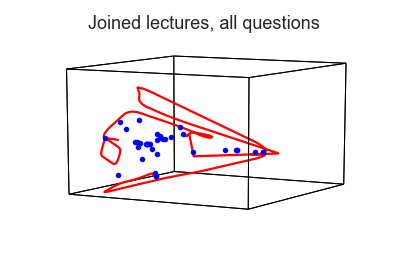

In [21]:
hyp.plot([lectures_traj, all_q_traj], fmt=['r-', 'b.'], title='Joined lectures, all questions')
plt.show()

## use current questions and all previous correctly answered questions

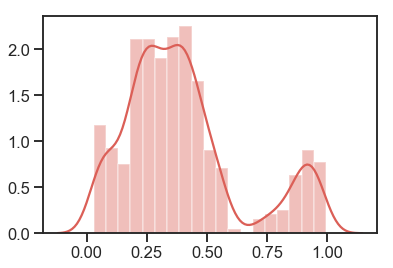

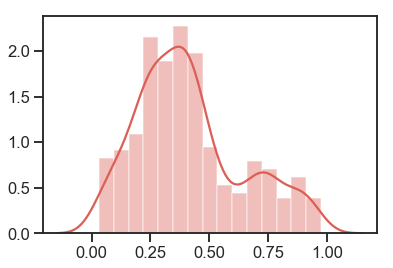

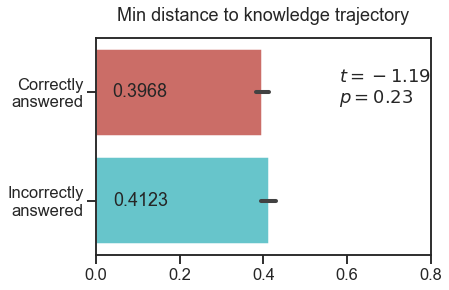

In [29]:
correct_dists = []
incorrect_dists = []

# for each participant
for sub, data in sub_data.items():
    # for each question set
    for qset in range(3):
        
        # get correctly answered questions from any previous sets
        prev_data = data.loc[(data.set < qset) & (data['correct?'])]
        if prev_data.empty:
            pass
        else:
            prev_qs = prev_data.qID.values - 1
            prevqs_traj = all_q_traj[prev_qs]
            prev_acc = prev_data['correct?'].tolist()
        
        
        # get current set's data, hold out one question
        set_data = data.loc[data.set == qset]
        for q_dropped in set_data.qID:
            
            # get topic vector and accuracy for heldout question
            qdropped_vec = all_q_traj[q_dropped - 1]
            qdropped_acc = set_data.loc[set_data.qID == q_dropped, 'correct?'].values[0]
            
            # get data for remaining questions
            otherq_data = set_data.loc[set_data.qID != q_dropped]
            qs = otherq_data.qID.values - 1
            qs_traj = all_q_traj[qs]
            acc = otherq_data['correct?'].tolist()
            
            # add correctly answered previous questions, if any
            if not prev_data.empty:
                qs_traj = np.append(prevqs_traj, qs_traj, axis=0)
                acc = prev_acc + acc
               
            # can't construct knowledge trajectory from all wrong answers
            if not any(acc):
                continue
            
            # construct trace from "all current knowledge"
            knowledge = reconstruct_trace(lectures_traj, qs_traj, acc)
            
            # shortest distance to held-out question
            mindist = cdist(knowledge, np.atleast_2d(qdropped_vec)).min()
            
            if qdropped_acc:
                correct_dists.append(mindist)
            else:
                incorrect_dists.append(mindist)
                
sns.distplot(correct_dists)
plt.show()
sns.distplot(incorrect_dists)
plt.show()

results = pd.DataFrame([correct_dists, incorrect_dists]).T
results.columns = ['Correctly\nanswered', 'Incorrectly\nanswered']
unstacked = results.unstack().to_frame()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,4)
sns.barplot(x=unstacked[0], y=unstacked.index.get_level_values(0), ax=ax)
ax.set_title('Min distance to knowledge trajectory', y=1.05)
ax.set_xlim(0,.8)
ax.set_xlabel('Topic space distance')
ax.set_xticks(np.arange(0,1,.2))
ax.set_xlabel('')

for p in ax.patches:
    ax.text(p.get_width()*.1, (p.get_y() + p.get_height()/2), format(p.get_width(), '.4f'), va='center')

t, p = ttest_ind(correct_dists, incorrect_dists)
t = '=' + str(round(t, 2))
if p >= 0.01:
    p = '=' + str(round(p, 2))
else:
    p = '<0.01'
ax.text(.58, -.1, f'$t{t}$')
ax.text(.58, .1, f'$p{p}$')
plt.show()

## consider all question content, but use only current questions

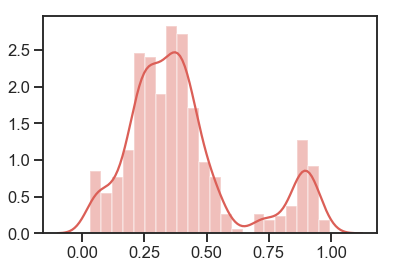

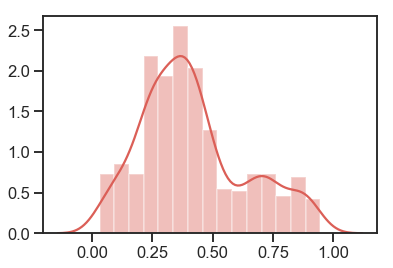

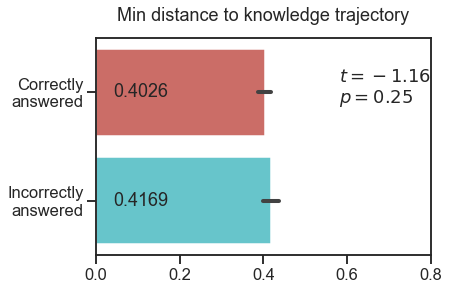

In [30]:
correct_dists = []
incorrect_dists = []

# for each participant
for sub, data in sub_data.items():
    # for each question set
    for qset in range(3):

        # get current set's data, hold out one question
        set_data = data.loc[data.set == qset]
        for q_dropped in set_data.qID:

            # get topic vector and accuracy for heldout question
            qdropped_vec = all_q_traj[q_dropped - 1]
            qdropped_acc = set_data.loc[set_data.qID == q_dropped, 'correct?'].values[0]

            # get data for remaining questions
            otherq_data = set_data.loc[set_data.qID != q_dropped]
            qs = otherq_data.qID.values - 1
            qs_traj = all_q_traj[qs]
            acc = otherq_data['correct?'].tolist()
            
            # can't construct knowledge trajectory from all wrong answers
            if not any(acc):
                continue

            # construct trace from "all current knowledge"
            knowledge = reconstruct_trace(lectures_traj, qs_traj, acc)

            # shortest distance to held-out question
            mindist = cdist(knowledge, np.atleast_2d(qdropped_vec)).min()

            if qdropped_acc:
                correct_dists.append(mindist)
            else:
                incorrect_dists.append(mindist)
                
sns.distplot(correct_dists)
plt.show()
sns.distplot(incorrect_dists)
plt.show()

results = pd.DataFrame([correct_dists, incorrect_dists]).T
results.columns = ['Correctly\nanswered', 'Incorrectly\nanswered']
unstacked = results.unstack().to_frame()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,4)
sns.barplot(x=unstacked[0], y=unstacked.index.get_level_values(0), ax=ax)
ax.set_title('Min distance to knowledge trajectory', y=1.05)
ax.set_xlim(0,.8)
ax.set_xlabel('Topic space distance')
ax.set_xticks(np.arange(0,1,.2))
ax.set_xlabel('')

for p in ax.patches:
    ax.text(p.get_width()*.1, (p.get_y() + p.get_height()/2), format(p.get_width(), '.4f'), va='center')

t, p = ttest_ind(correct_dists, incorrect_dists)
t = '=' + str(round(t, 2))
if p >= 0.01:
    p = '=' + str(round(p, 2))
else:
    p = '<0.01'
ax.text(.58, -.1, f'$t{t}$')
ax.text(.58, .1, f'$p{p}$')
plt.show()

## use all question sets, but only consider lecture-related questions (drop general knowledge)

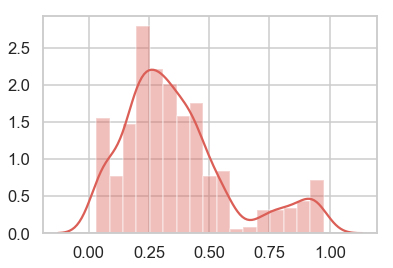

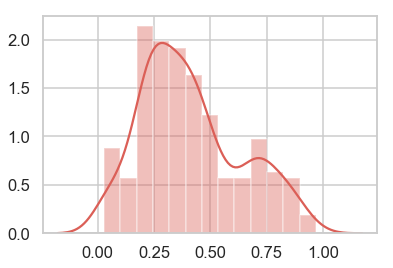

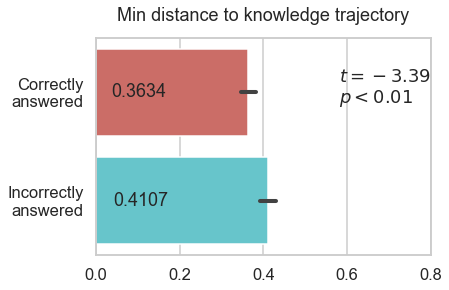

In [24]:
correct_dists = []
incorrect_dists = []

# for each participant
for sub, data in sub_data.items():
    # for each question set
    for qset in range(3):
        
        # get correctly answered questions from any previous sets
        prev_data = data.loc[(data.set < qset) & (data['correct?']) & (data.video != 0)]
        if prev_data.empty:
            pass
        else:
            prev_qs = prev_data.qID.values - 1
            prevqs_traj = all_q_traj[prev_qs]
            prev_acc = prev_data['correct?'].tolist()
        
        
        # get current set's data, hold out one question
        set_data = data.loc[(data.set == qset) & (data.video != 0)]
        for q_dropped in set_data.qID:
            
            # get topic vector and accuracy for heldout question
            qdropped_vec = all_q_traj[q_dropped - 1]
            qdropped_acc = set_data.loc[set_data.qID == q_dropped, 'correct?'].values[0]
            
            # get data for remaining questions
            otherq_data = set_data.loc[set_data.qID != q_dropped]
            qs = otherq_data.qID.values - 1
            qs_traj = all_q_traj[qs]
            acc = otherq_data['correct?'].tolist()
            
            # add correctly answered previous questions, if any
            if not prev_data.empty:
                qs_traj = np.append(prevqs_traj, qs_traj, axis=0)
                acc = prev_acc + acc
               
            # can't construct knowledge trajectory from all wrong answers
            if not any(acc):
                continue
            
            # construct trace from "all current knowledge"
            knowledge = reconstruct_trace(lectures_traj, qs_traj, acc)
            
            # shortest distance to held-out question
            mindist = cdist(knowledge, np.atleast_2d(qdropped_vec)).min()
            
            if qdropped_acc:
                correct_dists.append(mindist)
            else:
                incorrect_dists.append(mindist)
                
sns.distplot(correct_dists)
plt.show()
sns.distplot(incorrect_dists)
plt.show()

results = pd.DataFrame([correct_dists, incorrect_dists]).T
results.columns = ['Correctly\nanswered', 'Incorrectly\nanswered']
unstacked = results.unstack().to_frame()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,4)
sns.barplot(x=unstacked[0], y=unstacked.index.get_level_values(0), ax=ax)
ax.set_title('Min distance to knowledge trajectory', y=1.05)
ax.set_xlim(0,.8)
ax.set_xlabel('Topic space distance')
ax.set_xticks(np.arange(0,1,.2))
ax.set_xlabel('')

for p in ax.patches:
    ax.text(p.get_width()*.1, (p.get_y() + p.get_height()/2), format(p.get_width(), '.4f'), va='center')

t, p = ttest_ind(correct_dists, incorrect_dists)
t = '=' + str(round(t, 2))
if p >= 0.01:
    p = '=' + str(round(p, 2))
else:
    p = '<0.01'
ax.text(.58, -.1, f'$t{t}$')
ax.text(.58, .1, f'$p{p}$')
plt.savefig(f'{figdir}/fit_all/q_heldoud_traj_dist.pdf', bbox_inches='tight')
plt.show()

## use current question set only, and only consider lecture-related questions

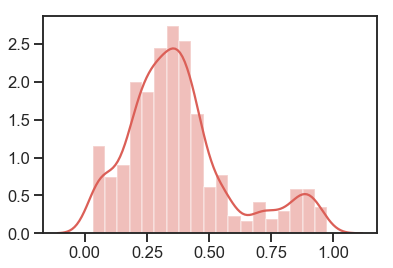

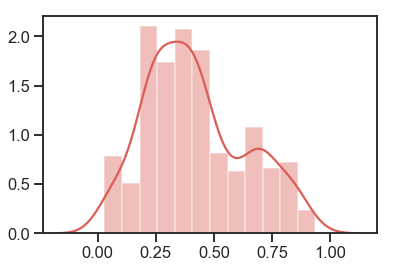

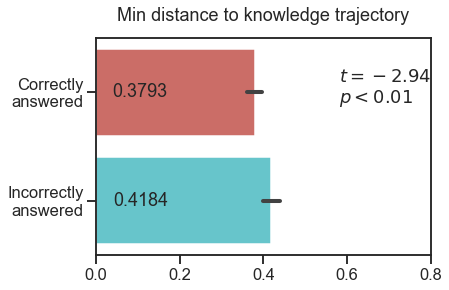

In [32]:
correct_dists = []
incorrect_dists = []

# for each participant
for sub, data in sub_data.items():
    # for each question set
    for qset in range(3):

        # get current set's data, hold out one question
        set_data = data.loc[(data.set == qset) & (data.video != 0)]
        for q_dropped in set_data.qID:

            # get topic vector and accuracy for heldout question
            qdropped_vec = all_q_traj[q_dropped - 1]
            qdropped_acc = set_data.loc[set_data.qID == q_dropped, 'correct?'].values[0]

            # get data for remaining questions
            otherq_data = set_data.loc[set_data.qID != q_dropped]
            qs = otherq_data.qID.values - 1
            qs_traj = all_q_traj[qs]
            acc = otherq_data['correct?'].tolist()
            
            # can't construct knowledge trajectory from all wrong answers
            if not any(acc):
                continue

            # construct trace from "all current knowledge"
            knowledge = reconstruct_trace(lectures_traj, qs_traj, acc)

            # shortest distance to held-out question
            mindist = cdist(knowledge, np.atleast_2d(qdropped_vec)).min()

            if qdropped_acc:
                correct_dists.append(mindist)
            else:
                incorrect_dists.append(mindist)

sns.distplot(correct_dists)
plt.show()
sns.distplot(incorrect_dists)
plt.show()

results = pd.DataFrame([correct_dists, incorrect_dists]).T
results.columns = ['Correctly\nanswered', 'Incorrectly\nanswered']
unstacked = results.unstack().to_frame()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,4)
sns.barplot(x=unstacked[0], y=unstacked.index.get_level_values(0), ax=ax)
ax.set_title('Min distance to knowledge trajectory', y=1.05)
ax.set_xlim(0,.8)
ax.set_xlabel('Topic space distance')
ax.set_xticks(np.arange(0,1,.2))
ax.set_xlabel('')

for p in ax.patches:
    ax.text(p.get_width()*.1, (p.get_y() + p.get_height()/2), format(p.get_width(), '.4f'), va='center')

t, p = ttest_ind(correct_dists, incorrect_dists)
t = '=' + str(round(t, 2))
if p >= 0.01:
    p = '=' + str(round(p, 2))
else:
    p = '<0.01'
ax.text(.58, -.1, f'$t{t}$')
ax.text(.58, .1, f'$p{p}$')
plt.show()

## predict correct vs incorrect by distance _n_ nearest correct answers

In [22]:
def meandist_nearest_n(question, others, n):
    """
    computes mean distance between the topic vectors of a given
    question and the nearest n other question
    """
    dists = cdist(np.atleast_2d(question), others).ravel()
    nearest_n = dists.argsort()[:n]
    return dists[nearest_n].mean()

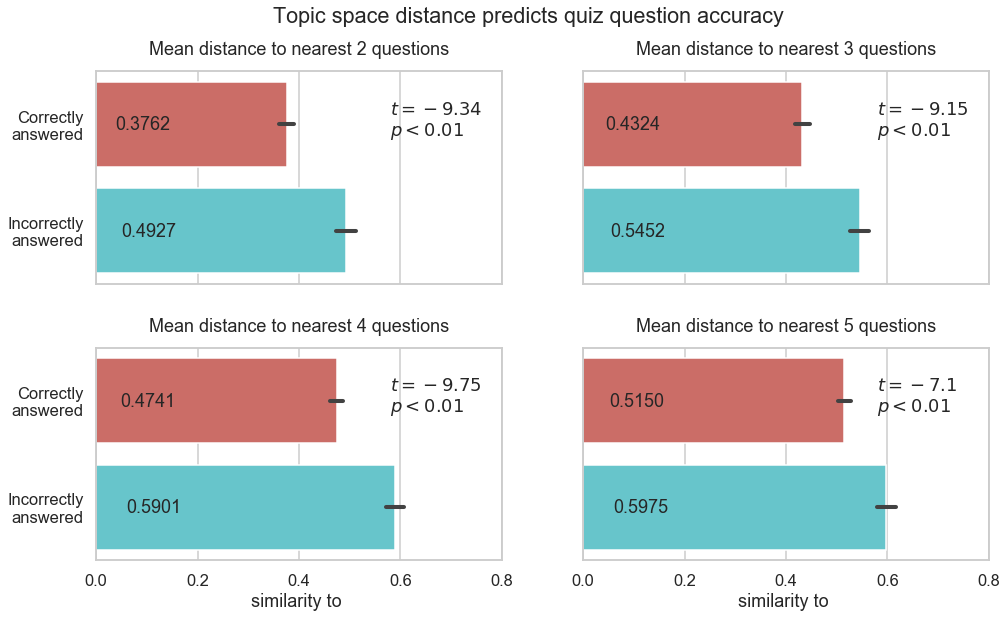

In [26]:
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(16, 9)
axarr = axarr.flatten()

for n, (i, ax) in zip(range(2, 6), enumerate(axarr)):
    correct_dists = []
    incorrect_dists = []

    for sub, data in sub_data.items():
        for qset in range(3):
            # get correctly answered questions from any previous sets
            prev_data = data.loc[(data.set < qset) & (data['correct?'])]
            if prev_data.empty:
                pass
            else:
                prev_qs = prev_data.qID.values - 1
                prevqs_vecs = all_q_traj[prev_qs]

            # get current set's data, test one question at a time
            set_data = data.loc[data.set == qset]
            for test_q in set_data.qID:

                # get topic vector and accuracy for test question
                testq_vec = all_q_traj[test_q - 1]
                testq_acc = set_data.loc[set_data.qID == test_q, 'correct?'].values[0]

                # get data for remaining (correctly answered) questions
                otherq_data = set_data.loc[(set_data.qID != test_q) & (set_data['correct?'])]

                # skip instances where not enough other questions were answered correctly
                if len(otherq_data) + len(prev_data) < n:
                    continue

                other_qs = otherq_data.qID.values - 1
                otherqs_vecs = all_q_traj[other_qs]

                # add correctly answered previous questions, if any
                if not prev_data.empty:
                    otherqs_vecs = np.append(prevqs_vecs, otherqs_vecs, axis=0)

                # mean distance to nearest n correct questions
                meandist_n = meandist_nearest_n(testq_vec, otherqs_vecs, n)

                if testq_acc:
                    correct_dists.append(meandist_n)
                else:
                    incorrect_dists.append(meandist_n)

    results = pd.DataFrame([correct_dists, incorrect_dists]).T
    results.columns = ['Correctly\nanswered', 'Incorrectly\nanswered']
    unstacked = results.unstack().to_frame()
    
    sns.barplot(x=unstacked[0], y=unstacked.index.get_level_values(0), ax=ax)
    ax.set_title(f'Mean distance to nearest {n} questions', y=1.05)
    ax.set_xlim(0,.8)
    if i > 1:
        ax.set_xlabel('similarity to ')
        ax.set_xticks(np.arange(0,1,.2))
    else:
        ax.set_xlabel('')

    for p in ax.patches:
        ax.text(p.get_width()*.1, (p.get_y() + p.get_height()/2), format(p.get_width(), '.4f'), va='center')

    t, p = ttest_ind(correct_dists, incorrect_dists)
    t = '=' + str(round(t, 2))
    if p >= 0.01:
        p = '=' + str(round(p, 2))
    else:
        p = '<0.01'
    ax.text(.58, -.1, f'$t{t}$')
    ax.text(.58, .1, f'$p{p}$')

plt.suptitle('Topic space distance predicts quiz question accuracy')
plt.subplots_adjust(hspace=.3)
plt.savefig(f'{figdir}/n_nearest_questions_dist.pdf', bbox_inches='tight')
plt.show()